In [1]:
#hide
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
input_file = 'owid-covid-data.csv'

df = pd.read_csv(input_file)
df['ds'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
df = df.sort_values(by=['ds'])

### Explore data

In [3]:
#Drop the continents
valuesToDrop = ['Asia', 'World', 'International', 'European Union', 'Europe', 'North America', 'Africa', 
                'South America', 'Oceania']
df1 = df[~(df['location'].isin(valuesToDrop))]
df1 = df1.dropna(subset=['new_cases'])

In [4]:
# Covid Cases distribution
cases_dist = px.sunburst(df1, path=['continent', 'location'], 
                   values = 'new_cases',
                   color='new_cases', 
                   color_continuous_scale = px.colors.sequential.Magenta,
                   title = 'Covid cases distribution'
                  )
# cases_dist.show()

In [5]:
#hide
pd.set_option('display.float_format', '{:.2f}'.format)
pd.pivot_table(df, values = ['population','population_density','new_cases'], index='continent', 
               aggfunc={'population': np.sum, 'population_density': np.mean, 'new_cases': np.sum})

,new_cases,population,population_density
continent,,,
Africa,7412801.00,710776387690.00,102.60
Asia,66244552.00,2593334831443.00,766.24
Europe,54546550.00,419499709755.00,599.37
North America,44758064.00,337058866381.00,211.54
Oceania,105674.00,22864384854.00,79.19
South America,36456176.00,235988506535.00,24.40


### Plotting covid new cases choropleth map

In [6]:
df2 = df.copy()
df2['ds'] = df2['ds'].astype(str)

fig = px.choropleth(df2, 
                  locations='iso_code',
                  color='new_cases',
                  hover_name='location',
                  animation_frame="ds",
                  color_continuous_scale=px.colors.sequential.Reds)
fig.show()

### Time Series Analysis

In [7]:
# Prepare the data for prophet
df4 = df.groupby(by=['ds'])['new_cases'].sum().reset_index().sort_values(by='ds', ascending=True)
df4 = df4.rename(columns={'new_cases':'y'})

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.54837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       938.957    0.00157276       128.333   1.907e-05       0.001      138  LS failed, Hessian reset 
      99       939.815   0.000128232       50.4087      0.7411      0.7411      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       940.955    0.00105143       72.7678   9.419e-06       0.001      274  LS failed, Hessian reset 
     199       941.504   1.17708e-05       69.7156      0.3262      0.3262      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       941.506   5.23168e-08        77.369      0.2579           1      423   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


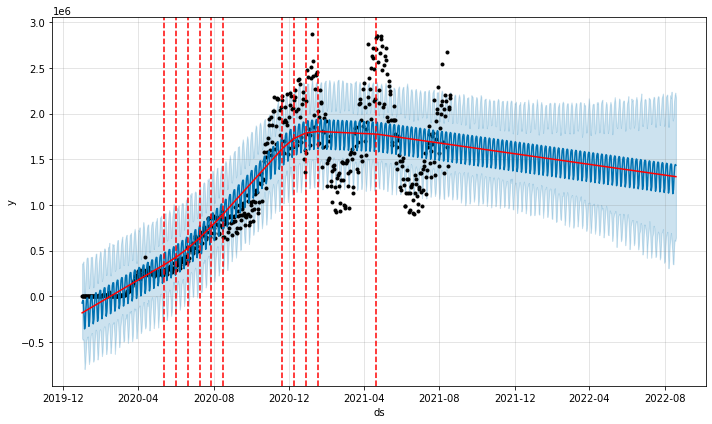

In [8]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

# instantiate the model, fit the timeseries to the model
model = Prophet().fit(df4)

# predict future cases
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
# fig;

### hyperparameters tuning

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.54837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       991.673     0.0359472       30.5977           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       1006.66   0.000135233       8.33226   6.068e-06       0.001      282  LS failed, Hessian reset 
     199       1006.69    0.00582461       19.6152           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1010.11    0.00610452       27.3128      0.1417      0.8632      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     397       1012.49   0.000425993       34.5145   2.078e-05       0.001      563  LS failed, Hessian reset 
     399       1012.59    0.00733377       11.8145           1           1      566   
    Iter      log pro

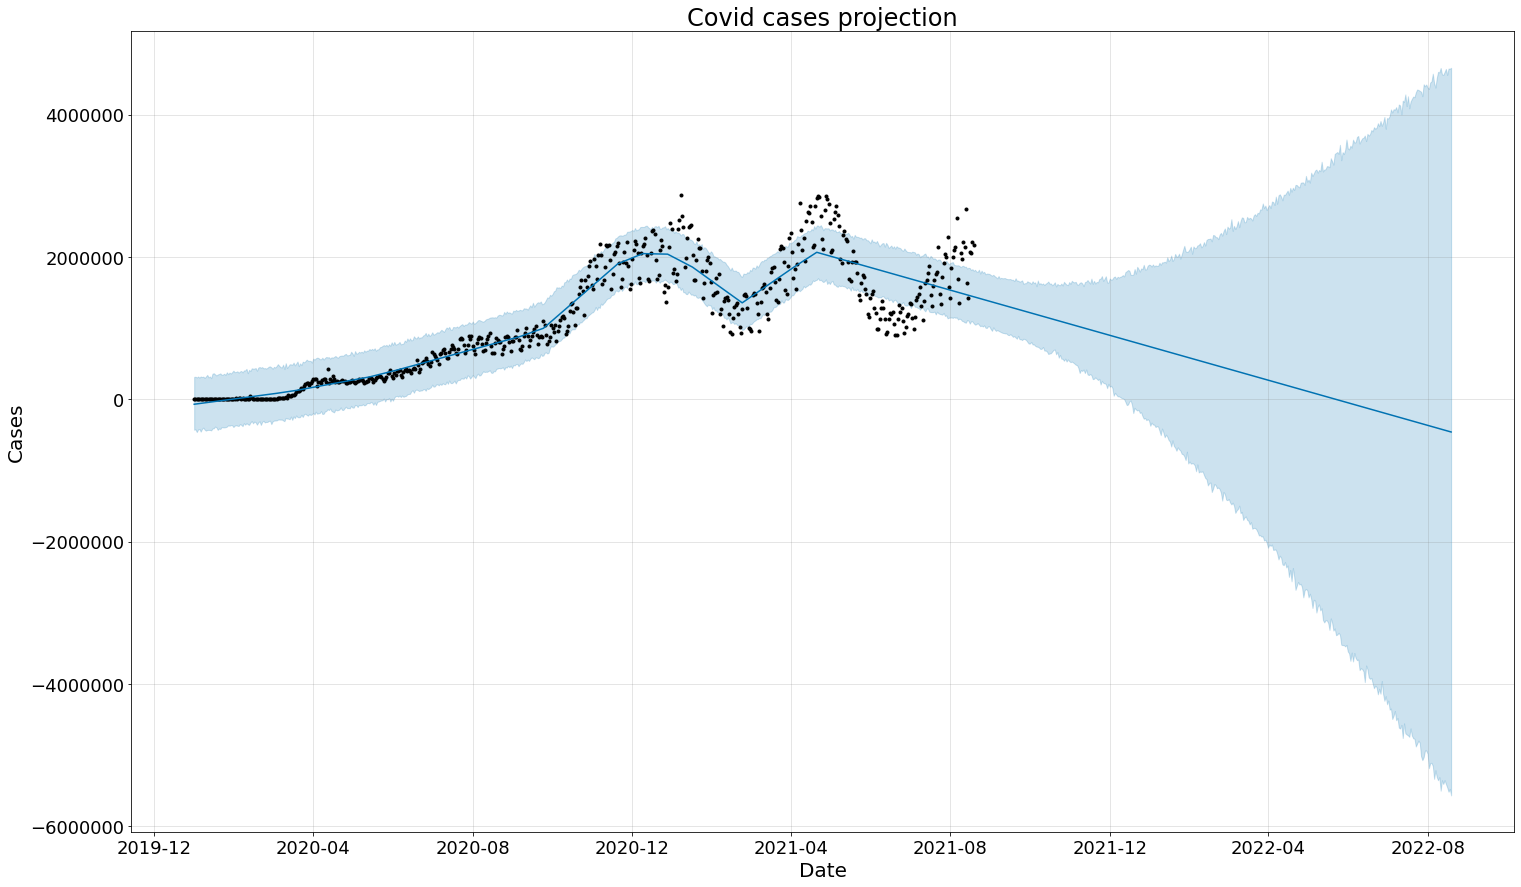

In [9]:
m = Prophet(weekly_seasonality=False, changepoint_prior_scale=0.4, changepoint_range=0.8).fit(df4)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

fig1 = m.plot(forecast, figsize=(20, 12))
ax = fig1.gca()
ax.set_title("Covid cases projection", size=24)
ax.set_xlabel('Date', size=20)
ax.set_ylabel('Cases', size=20)
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.yaxis.get_major_formatter().set_scientific(False)